In [276]:
import pandas as pd
import altair as alt
alt.renderers.set_embed_options(theme='dark')
pd.set_option('display.max_colwidth', None)

# Analysis & Charts

In [277]:
def claim(claim_hash):
    try:
        df_claim = pd.read_json(
            f'https://node-api.flipsidecrypto.com/api/v2/queries/{claim_hash}/data/latest',
            convert_dates=["BLOCK_TIMESTAMP"],
        )
    except Exception as e:
        print(e)
        return 
    return df_claim

In [278]:
class DataProvider:    
    
    def __init__(self):
        self.vote = 'a3efd3f0-724b-4a26-9f92-6083c7c52785'
        self.date_wallet = '074c2ad1-a842-442d-a0f5-6456b35be648'
        self.validators_voting_power = 'fe7c80cd-d061-4c66-8230-68f7776bafbb'
        self.validators = 'db245c79-577e-4aa0-876e-49e57556afaa'
    
    def get_vote(self):
        df = claim(self.vote)
        df.columns = [c.lower() for c in df.columns]
        return df
    
    def get_date_wallet(self):
        df = claim(self.date_wallet)
        df.columns = [c.lower() for c in df.columns]
        return df
    
    def get_validators(self):
        df = claim(self.validators)
        df.columns = [c.lower() for c in df.columns]
        return df
    
    def get_validators_voting_powers(self):
        df = claim(self.validators_voting_power)
        df.columns = [c.lower() for c in df.columns]
        df['day'] = df.day.apply(lambda x: str(x)[:10])
        df = df[df.day=='2022-05-12']
        return df
    
   

In [279]:
dp = DataProvider()

## Handle Validators

In [280]:
valid = dp.get_validators()
valid['address'] = valid.delegator_address
valid[valid.operator_address=='terravaloper1259cmu5zyklsdkmgstxhwqpe0utfe5hhyty0at']

,label,operator_address,delegator_address,vp_address,address
37,Orion.Money,terravaloper1259cmu5zyklsdkmgstxhwqpe0utfe5hhyty0at,terra1259cmu5zyklsdkmgstxhwqpe0utfe5hhyygjdc,terravalcons1ty43n6et4c2hc9ccpmrlvk3yj68lpxreekqgyd,terra1259cmu5zyklsdkmgstxhwqpe0utfe5hhyygjdc


In [281]:
valid_vp = dp.get_validators_voting_powers()
valid_vp['date'] = valid_vp['day'].apply(str)
valid_vp['vp_address'] = valid_vp.address
valid_vp.columns

Index(['day', 'address', 'voting_power', 'date', 'vp_address'], dtype='object')

In [282]:
votes = dp.get_vote()
votes['date'] = votes['date'].apply(lambda x: str(x)[:10])
votes.columns

Index(['date', 'address', 'blockchain', 'chain_id', 'tx_status', 'block_id',
       'block_timestamp', 'tx_id', 'msg_type', 'voter', 'voter_label_type',
       'voter_label_subtype', 'voter_address_label', 'voter_address_name',
       'proposal_id', 'option', 'voting_power', 'address_label_type',
       'address_label_subtype', 'address_label', 'address_name', 'balance',
       'balance_usd', 'balance_type', 'is_native', 'currency'],
      dtype='object')

In [283]:
valid_final = valid.merge(votes.drop(columns=['voting_power']),on='address')\
                   .merge(valid_vp.drop(columns=['address','date']), on=['vp_address'])
valid_final['balance'] = valid_final.voting_power
valid_final['date'] = valid_final['date']+' 00:00:00'
valid_final[valid_final.address=='terra1259cmu5zyklsdkmgstxhwqpe0utfe5hhyygjdc']

,label,operator_address,delegator_address,vp_address,address,date,blockchain,chain_id,tx_status,block_id,...,address_label_subtype,address_label,address_name,balance,balance_usd,balance_type,is_native,currency,day,voting_power
2,Orion.Money,terravaloper1259cmu5zyklsdkmgstxhwqpe0utfe5hhyty0at,terra1259cmu5zyklsdkmgstxhwqpe0utfe5hhyygjdc,terravalcons1ty43n6et4c2hc9ccpmrlvk3yj68lpxreekqgyd,terra1259cmu5zyklsdkmgstxhwqpe0utfe5hhyygjdc,2022-05-20 00:00:00,terra,columbus-5,SUCCEEDED,7710376,...,validator,Orion.Money,delegator_address,1.680850e+07,0.0,staked,True,LUNA,2022-05-12,1.680850e+07


## ----------------

In [284]:
df = dp.get_vote()
df[df.address.str.contains('9q4dv')]

,date,address,blockchain,chain_id,tx_status,block_id,block_timestamp,tx_id,msg_type,voter,...,voting_power,address_label_type,address_label_subtype,address_label,address_name,balance,balance_usd,balance_type,is_native,currency
4058,2022-05-18,terra185y6yqq9wfxwq58chunj3as3rdgf3jpde9q4dv,terra,columbus-5,SUCCEEDED,7680430,2022-05-18 18:51:28.158,96CB805BD59934B0F9842DA23947147C19D1CDC4F9C85FEF55B68955B0A16CE5,gov/MsgVote,terra185y6yqq9wfxwq58chunj3as3rdgf3jpde9q4dv,...,NaN,None,None,None,None,36000.0,6.427104,staked,True,LUNA


**Merge validators and normal users**

In [286]:
not_validators = df[~df.address.isin(valid_final.address.values)]
not_validators['validator'] = False
valid_final['validator'] = True
df = not_validators.append(valid_final[not_validators.columns])
df.date = pd.to_datetime(df.date)

<ipython-input-286-1a870f0b2588>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_validators['validator'] = False


In [287]:
df[df.address=='terra1259cmu5zyklsdkmgstxhwqpe0utfe5hhyygjdc']

,date,address,blockchain,chain_id,tx_status,block_id,block_timestamp,tx_id,msg_type,voter,...,address_label_type,address_label_subtype,address_label,address_name,balance,balance_usd,balance_type,is_native,currency,validator
2,2022-05-20,terra1259cmu5zyklsdkmgstxhwqpe0utfe5hhyygjdc,terra,columbus-5,SUCCEEDED,7710376,2022-05-20 22:59:05.095,4787E4BF3B47BF48F161BF1DFAA9747850D8196903667DC7B2B92F1EDF75BCC7,gov/MsgVote,terra1259cmu5zyklsdkmgstxhwqpe0utfe5hhyygjdc,...,operator,validator,Orion.Money,delegator_address,1.680850e+07,0.0,staked,True,LUNA,True


In [289]:
df.head()

,date,address,blockchain,chain_id,tx_status,block_id,block_timestamp,tx_id,msg_type,voter,...,address_label_type,address_label_subtype,address_label,address_name,balance,balance_usd,balance_type,is_native,currency,validator
0,2022-05-18,terra1zr8e8zst7ex3mu45en4udtgu2w20gnankwud22,terra,columbus-5,SUCCEEDED,7676810,2022-05-18 12:33:35.407,605D666A02308766BD27D0D7E3DFAFB5E578CBA2B4EEE24971A76E3FBED3A367,gov/MsgVote,terra1zr8e8zst7ex3mu45en4udtgu2w20gnankwud22,...,None,None,None,None,0.0,0.0,staked,True,LUNA,False
1,2022-05-18,terra1wv4354elu972vhzsyz8kvp5ft6a658qzhpex3d,terra,columbus-5,SUCCEEDED,7676608,2022-05-18 12:12:38.631,E7A96FD3E68F1D3CA8E7A85A4B24E17C5A501322763346293337D9F4C57B2F79,gov/MsgVote,terra1wv4354elu972vhzsyz8kvp5ft6a658qzhpex3d,...,None,None,None,None,0.0,0.0,staked,True,LUNA,False
2,2022-05-18,terra1pad3j0zqva82pf95nj73y2j768l4ke5rw9rauu,terra,columbus-5,SUCCEEDED,7676856,2022-05-18 12:38:21.190,1B13660511A38A53F54CDC43B1C0C1C9D0A65B0E0A5A333007AA2D38EFE61560,gov/MsgVote,terra1pad3j0zqva82pf95nj73y2j768l4ke5rw9rauu,...,None,None,None,None,0.0,0.0,staked,True,LUNA,False
3,2022-05-19,terra1dxve5zf2h67jdnhrpexamskawmtumh885kspym,terra,columbus-5,SUCCEEDED,7689903,2022-05-19 11:14:48.141,09E819D627EFDDBC20BFD7C30247C434A6F2248B0A5D80BBBE1E1744D8AE2A70,gov/MsgVote,terra1dxve5zf2h67jdnhrpexamskawmtumh885kspym,...,None,None,None,None,0.0,0.0,staked,True,LUNA,False
4,2022-05-19,terra1fsl70smtv94pxwm82stufn2pgzdgp0tz3puqcf,terra,columbus-5,SUCCEEDED,7691571,2022-05-19 14:07:33.940,0F7E35DA5B71986230416CE038698FAD5EA1BFF337E8DA1D476991A362C710F7,gov/MsgVote,terra1fsl70smtv94pxwm82stufn2pgzdgp0tz3puqcf,...,None,None,None,None,0.0,0.0,staked,True,LUNA,False


In [290]:
df.set_index('tx_id').to_json('../data/votes_tx.json')

In [291]:
df.option.unique()

array(['VOTE_OPTION_NO_WITH_VETO', 'VOTE_OPTION_YES', 'VOTE_OPTION_NO',
       'VOTE_OPTION_ABSTAIN'], dtype=object)

In [292]:
df['hours_since_start'] = (df.block_timestamp - df.block_timestamp.min()).apply(lambda x: x.total_seconds() / 3600)

In [293]:
df.option = df.option.map({'VOTE_OPTION_NO_WITH_VETO':'No with veto',
               'VOTE_OPTION_YES':'Yes',
               'VOTE_OPTION_NO':'No',
               'VOTE_OPTION_ABSTAIN':'Abstain'})

In [294]:
df.to_json('../data/votes.json',orient='records')

## Quick and dirty analysis

In [296]:
wc = dp.get_date_wallet()
wc['date'] = wc['min(date)']
wc['age'] = (pd.Timestamp('2022-05-20') - pd.to_datetime(wc.date)).apply(lambda x: x.total_seconds()/3600/24)

In [297]:
def typew(date):
    if(date<'2021-09-30'):
        return 'Pre-Col5'
    if((date>='2021-09-30')&(date<='2022-05-07')):
        return 'Post-Col5'
    if((date>'2021-05-07')):
        return 'Post-DePeg'

wc['typew'] = wc.date.apply(typew)

In [298]:
df.merge(wc[['address','age']], on='address', how='left').to_json('../data/votes.json',orient='records')

In [299]:
m = wc.merge(df, on='address')

<AxesSubplot:title={'center':'Number of Users'}>

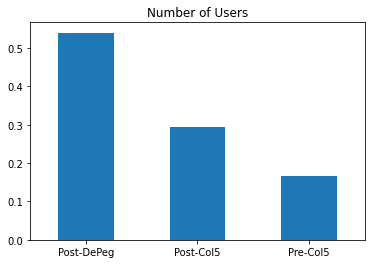

In [300]:
m.typew.value_counts(normalize=True).plot(kind='bar',rot=0, title='Number of Users')

<AxesSubplot:title={'center':'Voting Power'}, xlabel='typew'>

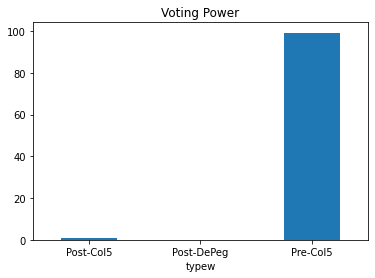

In [301]:
dfm = (m.groupby('typew').balance.sum())/1000000
(dfm/dfm.sum()*100).plot(kind='bar', rot=0, title='Voting Power')

<AxesSubplot:title={'center':'Pre-Col5'}>

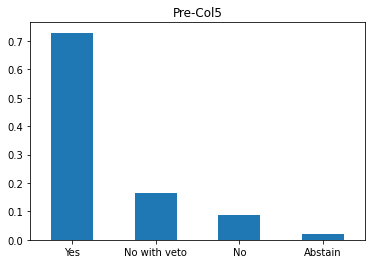

In [302]:
t='Pre-Col5'
m[m.typew==t].option.value_counts(normalize=True).plot(kind='bar', rot=0, title=t)

In [303]:
m[m.typew=='Post-DePeg'].option.value_counts(normalize=True)

Yes             0.717654
No with veto    0.220024
No              0.057701
Abstain         0.004621
Name: option, dtype: float64

In [304]:
m[m.typew=='Post-Col5'].option.value_counts(normalize=True)

Yes             0.631315
No with veto    0.232578
No              0.124564
Abstain         0.011542
Name: option, dtype: float64

In [305]:
m[m.typew=='Pre-Col5'].option.value_counts(normalize=True)

Yes             0.729375
No with veto    0.164225
No              0.087124
Abstain         0.019275
Name: option, dtype: float64

In [307]:
m[m.validator].option.value_counts(normalize=True)

Yes        0.80
Abstain    0.15
No         0.05
Name: option, dtype: float64

<AxesSubplot:title={'center':'Validators'}>

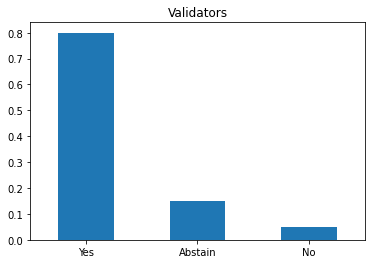

In [309]:
m[m.validator].option.value_counts(normalize=True).plot(kind='bar', rot=0, title='Validators')